In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/IMSAI/image.zip -d /content/sample_data/

Archive:  /content/drive/MyDrive/IMSAI/image.zip
  inflating: /content/sample_data/image/o_1.png  
  inflating: /content/sample_data/image/o_10.png  
  inflating: /content/sample_data/image/o_100.png  
  inflating: /content/sample_data/image/o_101.jpg  
  inflating: /content/sample_data/image/o_102.jpg  
  inflating: /content/sample_data/image/o_103.jpg  
  inflating: /content/sample_data/image/o_104.jpg  
  inflating: /content/sample_data/image/o_105.jpg  
  inflating: /content/sample_data/image/o_106.jpg  
  inflating: /content/sample_data/image/o_107.jpg  
  inflating: /content/sample_data/image/o_108.jpg  
  inflating: /content/sample_data/image/o_109.jpg  
  inflating: /content/sample_data/image/o_11.png  
  inflating: /content/sample_data/image/o_110.jpg  
  inflating: /content/sample_data/image/o_111.jpg  
  inflating: /content/sample_data/image/o_112.jpg  
  inflating: /content/sample_data/image/o_113.jpg  
  inflating: /content/sample_data/image/o_114.jpg  
  inflating: /conte

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

path = r"/content/sample_data/image"
def findFiles(path): return glob.glob(path)
#데이터 불러오기

In [ ]:
num_epochs = 15  # 에폭 5 10 15 20

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import random

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = True  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

# 이미지 파일 리스트 생성
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.ToTensor()

dataset = []
labels = []



# 이미지 전처리
for idx in image_list:
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150, 150))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels)), [train_size, test_size])


batch_size = 100  # 배치 사이즈 60(69) 64(75) 85(76) 100(71) 여기 다시
learning_rate = 0.0001  # 러닝 레이트 0.01(57),0.001(75) ,0.0005(75)), 0.0001(66)
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5
padding = 1  # 패딩 0 2 3
stride = 1  # 스트라이드 2 3 4
kernel_size = 3  # 커널 사이즈  3, 5, 7, 9
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36] # 채널 크기 [1, 4, 36](69), [1, 8, 64](67), [1, 16, 128](76), [1, 32, 256](73) -> [1, 32, 256]이걸로 설정하기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5



lists = [2,2,2,2]
for i in lists:
  print("num_hidden_layers")
  print(i)
  num_hidden_layers = i


  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


  class CNN(nn.Module):
      def __init__(self):
          super(CNN, self).__init__()
          self.conv1 = nn.Sequential(
              nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
              normalization(channels[1]),
              activation_function(),
              nn.MaxPool2d(2))

          self.conv2 = nn.Sequential(
              nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
              normalization(channels[2]),
              activation_function(),
              nn.MaxPool2d(2))

          self.fc = nn.Linear(channels[2] * 37 * 37, 2)

      def forward(self, x):
          x = self.conv1(x)
          x = self.conv2(x)
          x = x.view(x.size(0), -1)
          x = self.fc(x)
          return x

  model = CNN()
  optimizer = optimizer_function(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  # 모델 학습
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

  # 모델 성능 평가
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Result: {100 * correct / total}%')


num_hidden_layers
2
Epoch [1/5], Loss: 0.6332
Epoch [2/5], Loss: 0.3656
Epoch [3/5], Loss: 0.3038
Epoch [4/5], Loss: 0.2490
Epoch [5/5], Loss: 0.1716
Result: 85.71428571428571%
num_hidden_layers
2
Epoch [1/5], Loss: 0.6171
Epoch [2/5], Loss: 0.3787
Epoch [3/5], Loss: 0.2170
Epoch [4/5], Loss: 0.1814
Epoch [5/5], Loss: 0.1143
Result: 91.07142857142857%
num_hidden_layers
2
Epoch [1/5], Loss: 0.6661
Epoch [2/5], Loss: 0.3499
Epoch [3/5], Loss: 0.2410
Epoch [4/5], Loss: 0.2237
Epoch [5/5], Loss: 0.1357
Result: 91.07142857142857%
num_hidden_layers
2
Epoch [1/5], Loss: 0.7271
Epoch [2/5], Loss: 0.3998
Epoch [3/5], Loss: 0.2982
Epoch [4/5], Loss: 0.2816
Epoch [5/5], Loss: 0.2092
Result: 89.28571428571429%


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

path = r"/content/sample_data/image"
def findFiles(path): return glob.glob(path)

Epoch [1/5], Train Loss: 0.6099, Train Accuracy: 60.27%, Val Loss: 0.6808, Val Accuracy: 51.79%
Epoch [2/5], Train Loss: 0.4469, Train Accuracy: 75.45%, Val Loss: 0.6403, Val Accuracy: 66.07%
Epoch [3/5], Train Loss: 0.3458, Train Accuracy: 87.05%, Val Loss: 0.6091, Val Accuracy: 69.64%
Epoch [4/5], Train Loss: 0.2685, Train Accuracy: 89.73%, Val Loss: 0.5742, Val Accuracy: 67.86%
Epoch [5/5], Train Loss: 0.1630, Train Accuracy: 90.18%, Val Loss: 0.5639, Val Accuracy: 67.86%
Result: 67.85714285714286%
Image 6:  Incorrect!
True Label: X, Predicted Label: O


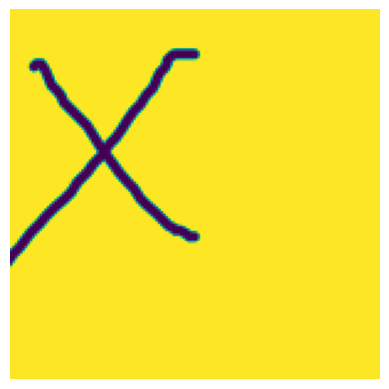

Image 7:  Incorrect!
True Label: X, Predicted Label: O


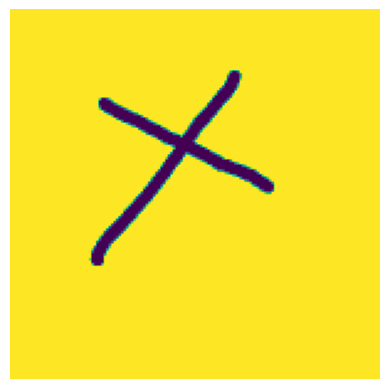

Image 8:  Incorrect!
True Label: X, Predicted Label: O


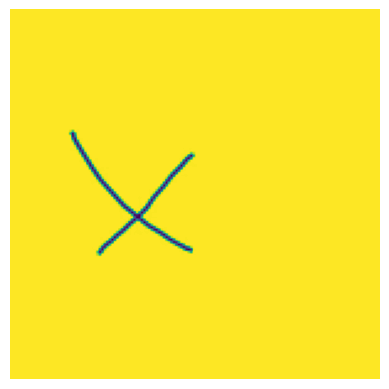

Image 10:  Incorrect!
True Label: X, Predicted Label: O


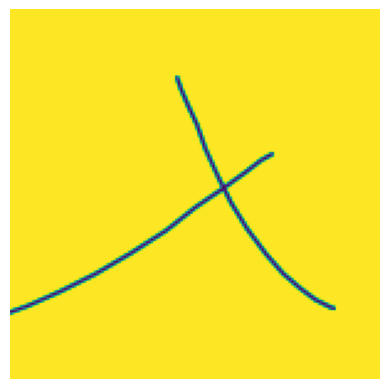

Image 11:  Incorrect!
True Label: X, Predicted Label: O


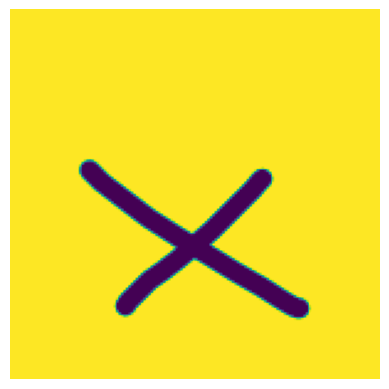

Image 17:  Incorrect!
True Label: X, Predicted Label: O


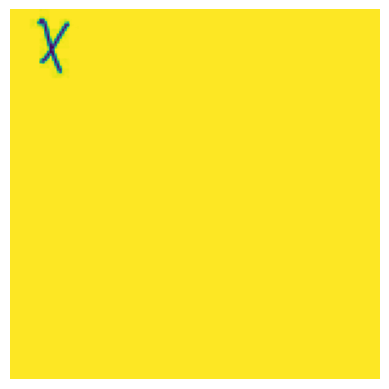

Image 21:  Incorrect!
True Label: X, Predicted Label: O


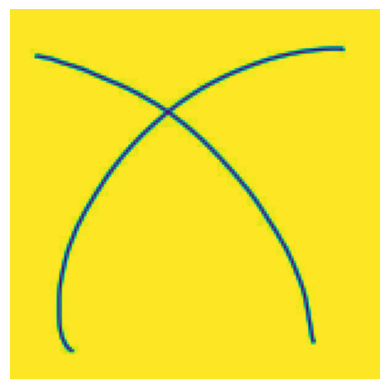

Image 22:  Incorrect!
True Label: X, Predicted Label: O


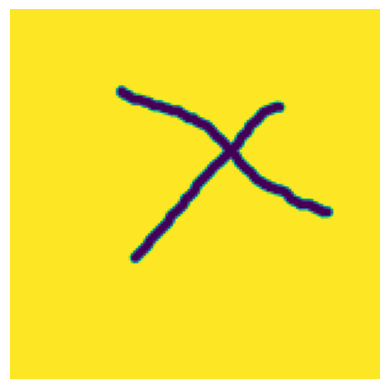

Image 25:  Incorrect!
True Label: X, Predicted Label: O


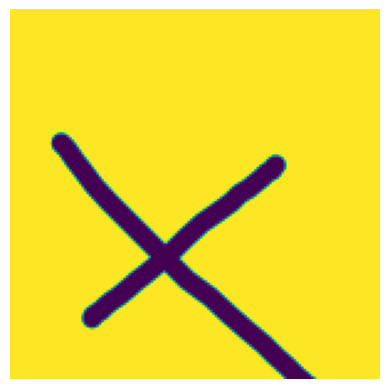

Image 27:  Incorrect!
True Label: X, Predicted Label: O


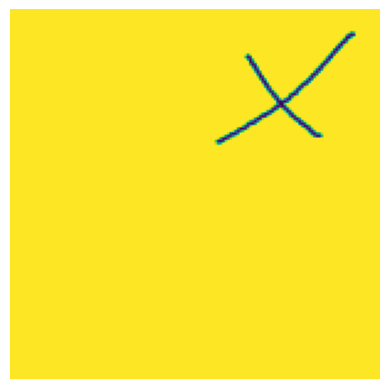

Image 28:  Incorrect!
True Label: X, Predicted Label: O


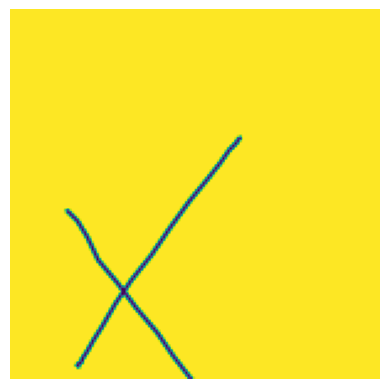

Image 32:  Incorrect!
True Label: X, Predicted Label: O


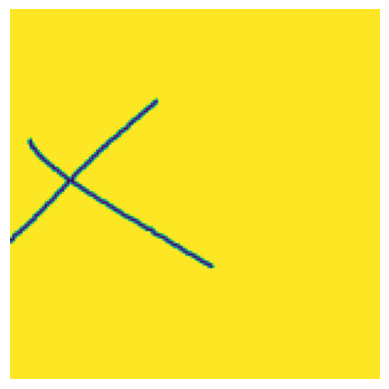

Image 37:  Incorrect!
True Label: X, Predicted Label: O


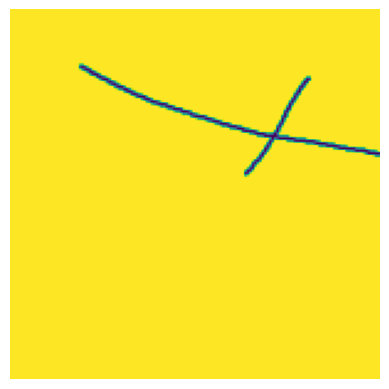

Image 38:  Incorrect!
True Label: X, Predicted Label: O


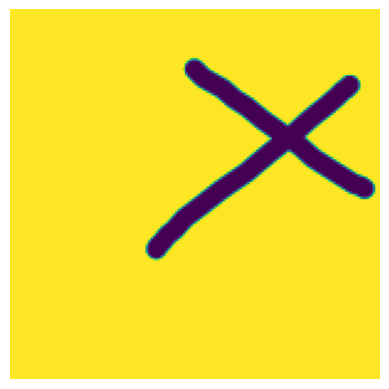

Image 46:  Incorrect!
True Label: X, Predicted Label: O


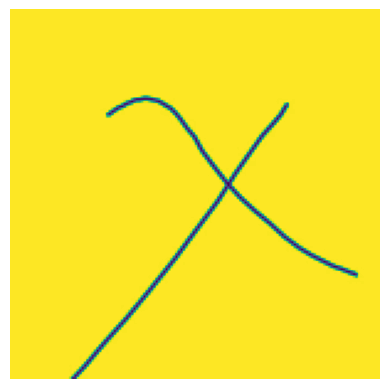

Image 50:  Incorrect!
True Label: O, Predicted Label: X


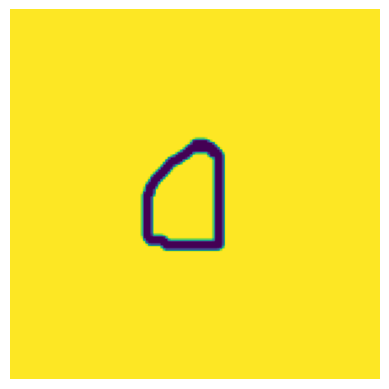

Image 55:  Incorrect!
True Label: X, Predicted Label: O


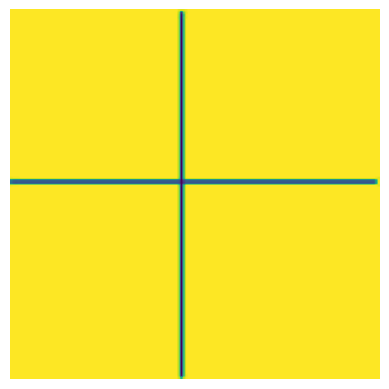

Image 56:  Incorrect!
True Label: X, Predicted Label: O


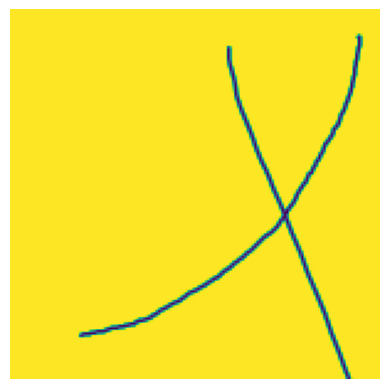

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.ToTensor()

dataset = []
labels = []

# 이미지 전처리
for idx in image_list:
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150, 150))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels)), [train_size, test_size])

batch_size = 100  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 모델 성능 평가 및 이미지 분류 결과 출력
correct = 0
total = 0
classified_results = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 분류 결과 저장
        for i in range(len(inputs)):
            classified_results.append((inputs[i], labels[i].item(), predicted[i].item()))

print(f'Result: {100 * correct / total}%')

# 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label) in enumerate(classified_results):
    image_np = image.numpy().transpose((1, 2, 0))
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
    if true_label == predicted_label:
        #print(f"Image {i + 1}:  Correct!")
        None
    else:
        print(f"Image {i + 1}:  Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()
    #print(f"Image {i + 1}: True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
    image_pil.show()


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

path = r"/content/sample_data/image"
def findFiles(path): return glob.glob(path)

Epoch [1/5], Train Loss: 0.6579, Train Accuracy: 54.91%, Val Loss: 0.6905, Val Accuracy: 46.43%
Epoch [2/5], Train Loss: 0.4289, Train Accuracy: 79.46%, Val Loss: 0.6520, Val Accuracy: 58.93%
Epoch [3/5], Train Loss: 0.2964, Train Accuracy: 87.95%, Val Loss: 0.6220, Val Accuracy: 66.07%
Epoch [4/5], Train Loss: 0.2362, Train Accuracy: 91.07%, Val Loss: 0.6049, Val Accuracy: 78.57%
Epoch [5/5], Train Loss: 0.1808, Train Accuracy: 93.30%, Val Loss: 0.5640, Val Accuracy: 82.14%
Result: 82.14285714285714%
Image 1 (o_70.png):  Incorrect!
True Label: O, Predicted Label: X


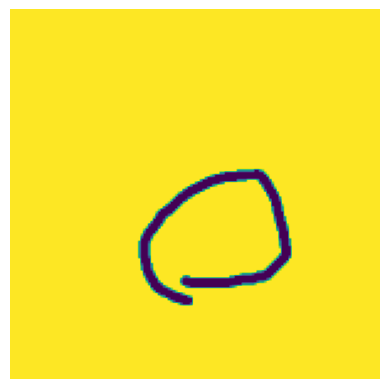

Image 3 (x_16.png):  Incorrect!
True Label: X, Predicted Label: O


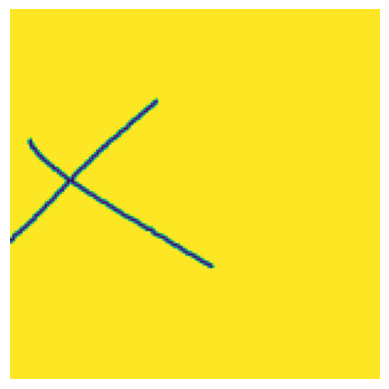

Image 4 (o_54.png):  Incorrect!
True Label: O, Predicted Label: X


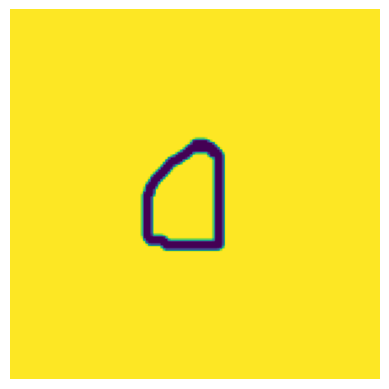

Image 7 (o_47.png):  Incorrect!
True Label: O, Predicted Label: X


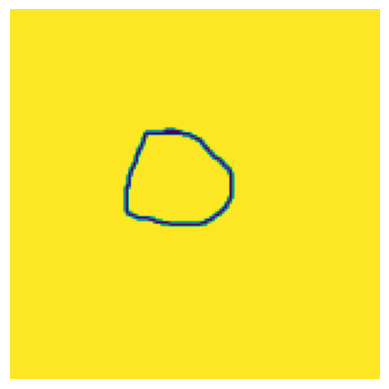

Image 12 (o_73.png):  Incorrect!
True Label: O, Predicted Label: X


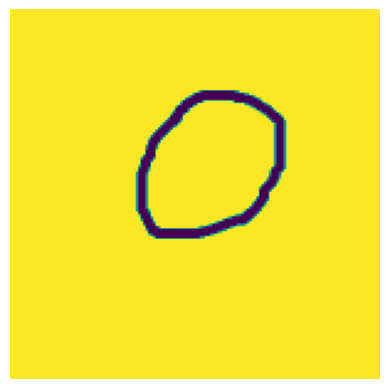

Image 20 (o_39.jpg):  Incorrect!
True Label: O, Predicted Label: X


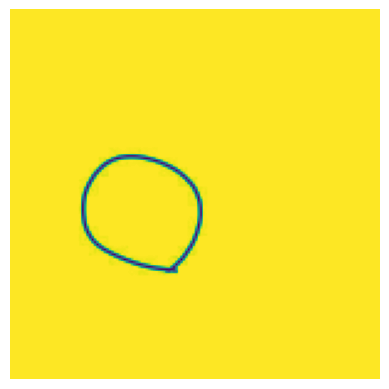

Image 32 (o_136.png):  Incorrect!
True Label: O, Predicted Label: X


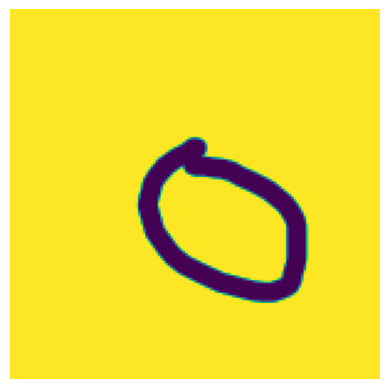

Image 47 (o_35.jpg):  Incorrect!
True Label: O, Predicted Label: X


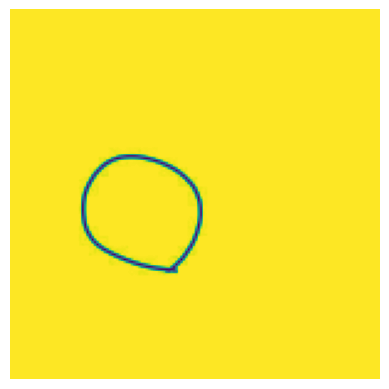

Image 49 (o_63.png):  Incorrect!
True Label: O, Predicted Label: X


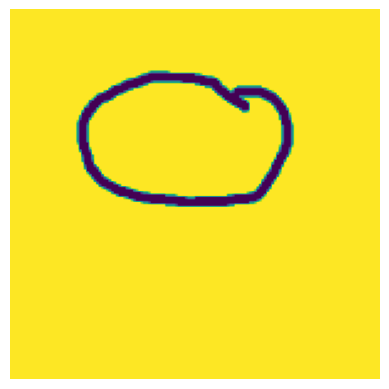

Image 52 (o_36.jpg):  Incorrect!
True Label: O, Predicted Label: X


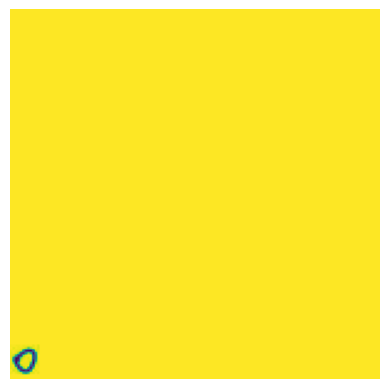

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.ToTensor()

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150, 150))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels, filenames)), [train_size, test_size])

batch_size = 100  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 모델 성능 평가 및 이미지 분류 결과 출력
correct = 0
total = 0
classified_results = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 분류 결과 저장
        for i in range(len(inputs)):
            classified_results.append((inputs[i], labels[i].item(), predicted[i].item(), filenames[i]))

print(f'Result: {100 * correct / total}%')

# 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(classified_results):
    image_np = image.numpy().transpose((1, 2, 0))
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
    if true_label == predicted_label:
        #print(f"Image {i + 1}:  Correct!")
        None
    else:
        print(f"Image {i + 1} ({filename}):  Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()
    #print(f"Image {i + 1}: True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
    image_pil.show()


Epoch [1/5], Train Loss: 0.5219, Train Accuracy: 69.20%, Val Loss: 0.6798, Val Accuracy: 50.00%
Epoch [2/5], Train Loss: 0.2253, Train Accuracy: 90.62%, Val Loss: 0.6397, Val Accuracy: 53.57%
Epoch [3/5], Train Loss: 0.1383, Train Accuracy: 95.98%, Val Loss: 0.5198, Val Accuracy: 76.79%
Epoch [4/5], Train Loss: 0.0904, Train Accuracy: 98.66%, Val Loss: 0.4808, Val Accuracy: 73.21%
Epoch [5/5], Train Loss: 0.0569, Train Accuracy: 99.55%, Val Loss: 0.4174, Val Accuracy: 80.36%
Result: 80.35714285714286%
Image 1 (x_45.png):  Incorrect!
True Label: X, Predicted Label: O


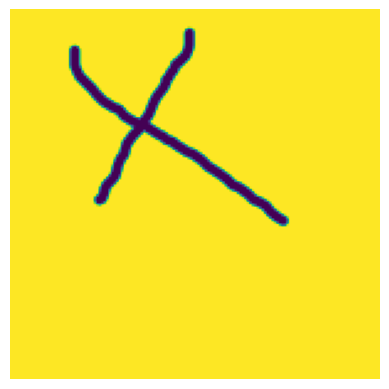

Image 2 (o_136.png):  Incorrect!
True Label: O, Predicted Label: X


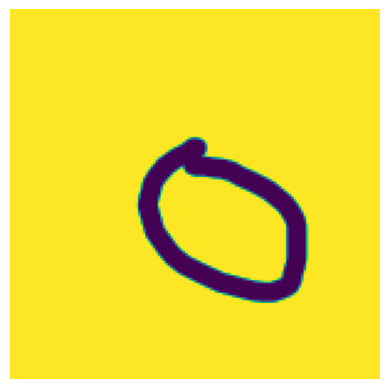

Image 5 (x_11.png):  Incorrect!
True Label: X, Predicted Label: O


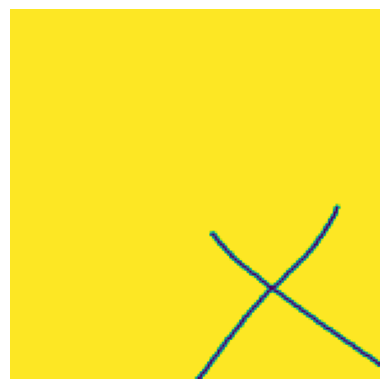

Image 8 (x_86.png):  Incorrect!
True Label: X, Predicted Label: O


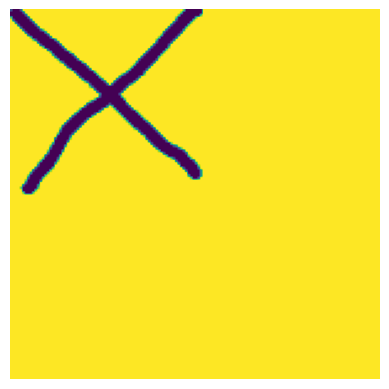

Image 12 (o_23.jpg):  Incorrect!
True Label: O, Predicted Label: X


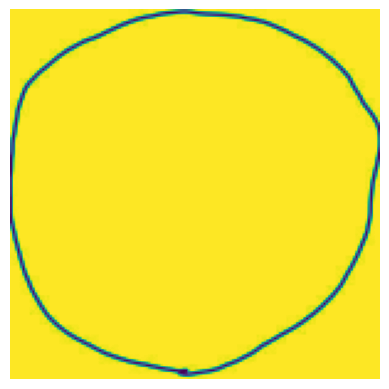

Image 15 (x_128.png):  Incorrect!
True Label: X, Predicted Label: O


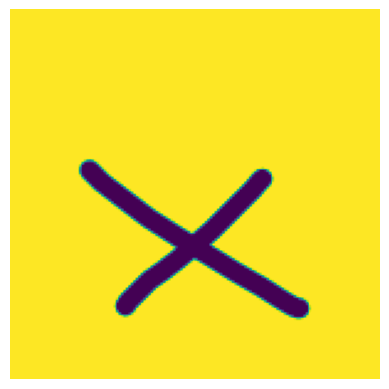

Image 20 (x_65.png):  Incorrect!
True Label: X, Predicted Label: O


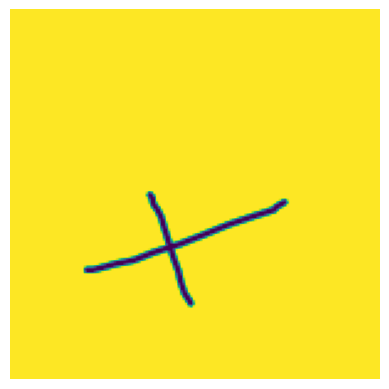

Image 21 (o_70.png):  Incorrect!
True Label: O, Predicted Label: X


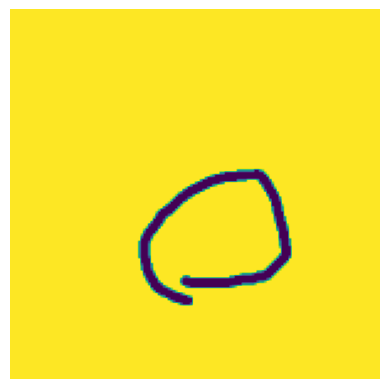

Image 43 (o_27.jpg):  Incorrect!
True Label: O, Predicted Label: X


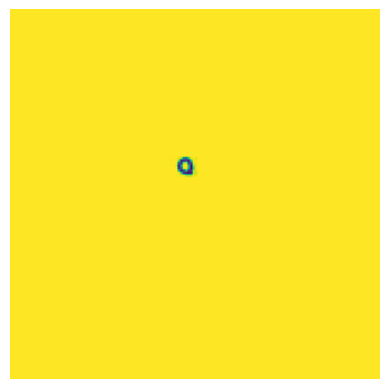

Image 46 (o_36.jpg):  Incorrect!
True Label: O, Predicted Label: X


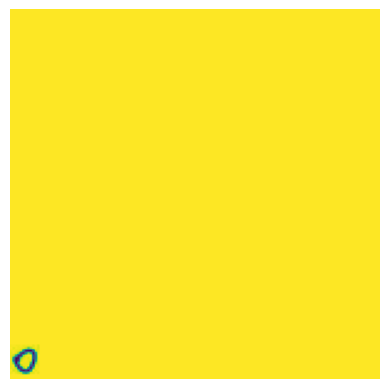

Image 48 (o_14.png):  Incorrect!
True Label: O, Predicted Label: X


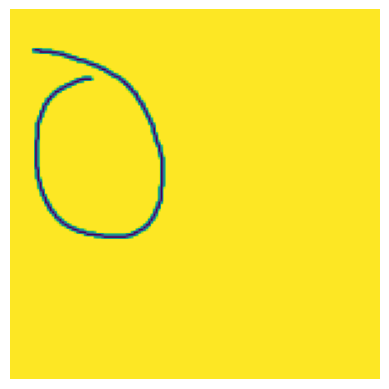

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.ToTensor()

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150, 150))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels, filenames)), [train_size, test_size])

batch_size = 32  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 모델 성능 평가 및 이미지 분류 결과 출력
correct = 0
total = 0
classified_results = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 분류 결과 저장
        for i in range(len(inputs)):
            classified_results.append((inputs[i], labels[i].item(), predicted[i].item(), filenames[i]))

print(f'Result: {100 * correct / total}%')

# 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(classified_results):
    image_np = image.numpy().transpose((1, 2, 0))
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
    if true_label == predicted_label:
        #print(f"Image {i + 1}:  Correct!")
        None
    else:
        print(f"Image {i + 1} ({filename}):  Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()
    #print(f"Image {i + 1}: True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
    image_pil.show()


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

path = r"/content/sample_data/image"
def findFiles(path): return glob.glob(path)

Epoch [1/5], Train Loss: 0.5740, Train Accuracy: 66.52%, Val Loss: 0.7010, Val Accuracy: 46.43%
Epoch [2/5], Train Loss: 0.3352, Train Accuracy: 83.93%, Val Loss: 0.6263, Val Accuracy: 80.36%
Epoch [3/5], Train Loss: 0.2442, Train Accuracy: 89.73%, Val Loss: 0.5717, Val Accuracy: 75.00%
Epoch [4/5], Train Loss: 0.1795, Train Accuracy: 93.75%, Val Loss: 0.4995, Val Accuracy: 80.36%
Epoch [5/5], Train Loss: 0.1396, Train Accuracy: 96.43%, Val Loss: 0.4550, Val Accuracy: 76.79%
Result: 76.78571428571429%
Image 3 (o_50.png):  Incorrect!
True Label: O, Predicted Label: X


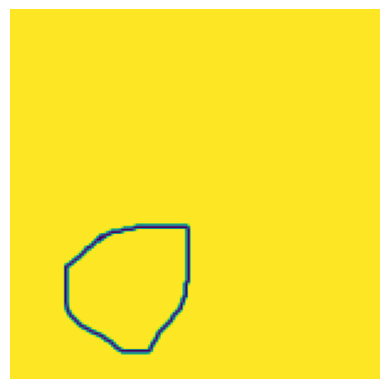

Image 8 (x_42.png):  Incorrect!
True Label: X, Predicted Label: O


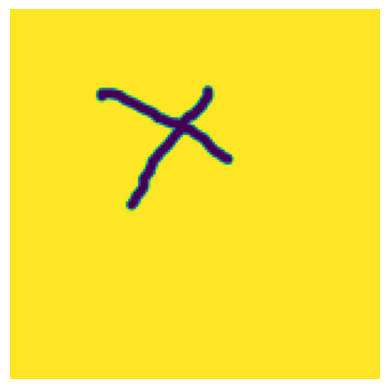

Image 16 (x_69.png):  Incorrect!
True Label: X, Predicted Label: O


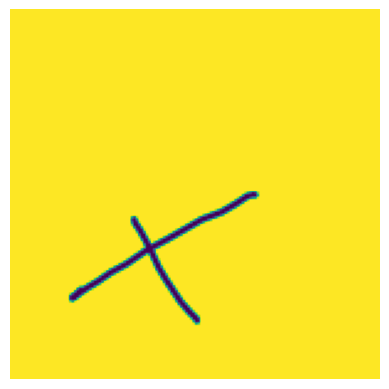

Image 18 (x_2.png):  Incorrect!
True Label: X, Predicted Label: O


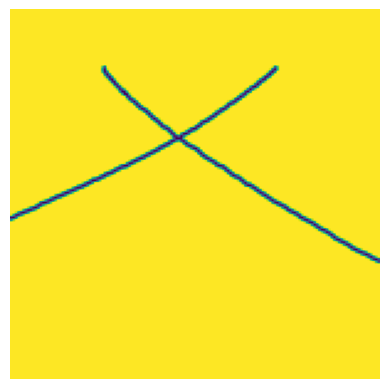

Image 21 (x_78.png):  Incorrect!
True Label: X, Predicted Label: O


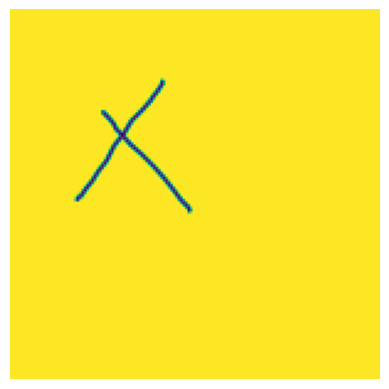

Image 23 (o_70.png):  Incorrect!
True Label: O, Predicted Label: X


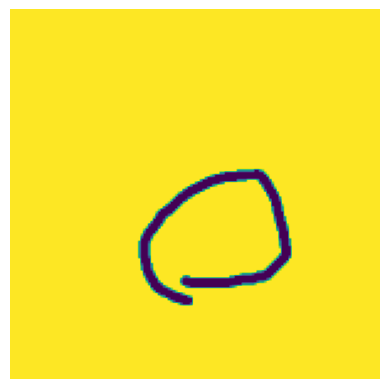

Image 28 (x_104.jpg):  Incorrect!
True Label: X, Predicted Label: O


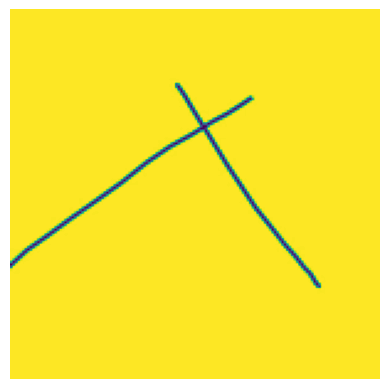

Image 31 (o_23.jpg):  Incorrect!
True Label: O, Predicted Label: X


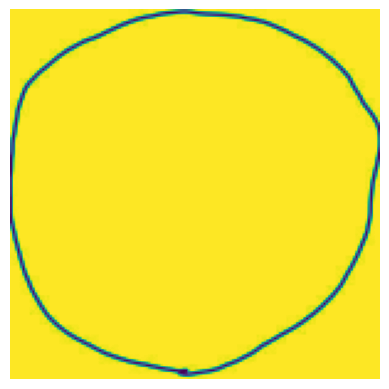

Image 32 (x_124.png):  Incorrect!
True Label: X, Predicted Label: O


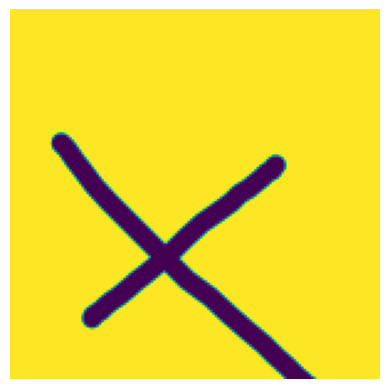

Image 33 (o_127.png):  Incorrect!
True Label: O, Predicted Label: X


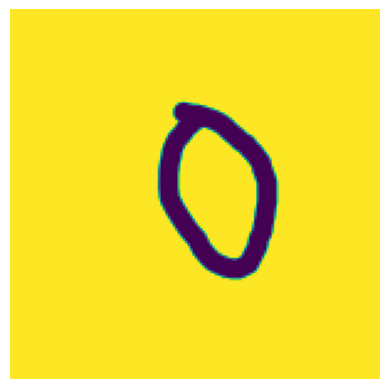

Image 35 (o_51.png):  Incorrect!
True Label: O, Predicted Label: X


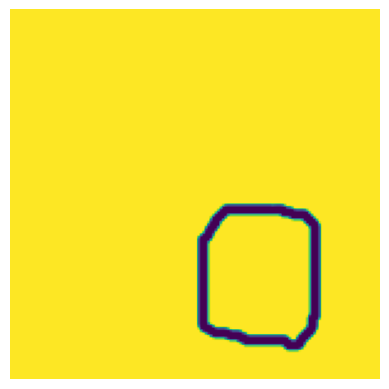

Image 41 (x_44.png):  Incorrect!
True Label: X, Predicted Label: O


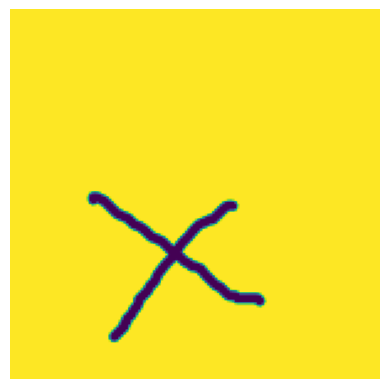

Image 50 (o_110.jpg):  Incorrect!
True Label: O, Predicted Label: X


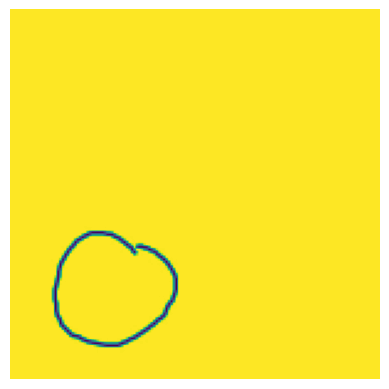

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.ToTensor()

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150, 150))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels, filenames)), [train_size, test_size])

batch_size = 32  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# import nn.functional for one-hot encoding
import torch.nn.functional as F

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.sigmoid = nn.Sigmoid()  # sigmoid 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)  # sigmoid 적용
        return x

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()  # BCELoss 사용

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        labels = F.one_hot(labels, num_classes=2).float()  # 원-핫 인코딩 적용
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == torch.max(labels, 1)[1]).sum().item()  # 정답 비교 수정

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            labels = F.one_hot(labels, num_classes=2).float()  # 원-핫 인코딩 적용
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == torch.max(labels, 1)[1]).sum().item()  # 정답 비교 수정

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 모델 성능 평가 및 이미지 분류 결과 출력
correct = 0
total = 0
classified_results = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        labels = F.one_hot(labels, num_classes=2).float()  # 원-핫 인코딩 적용
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()  # 정답 비교 수정

        # 분류 결과 저장
        for i in range(len(inputs)):
            classified_results.append((inputs[i], torch.max(labels[i], 0)[1].item(), predicted[i].item(), filenames[i]))

print(f'Result: {100 * correct / total}%')

# 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(classified_results):
    image_np = image.numpy().transpose((1, 2, 0))
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
    if true_label == predicted_label:
        #print(f"Image {i + 1}:  Correct!")
        None
    else:
        print(f"Image {i + 1} ({filename}):  Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()
    #print(f"Image {i + 1}: True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
    image_pil.show()


Epoch [1/5], Train Loss: 0.6416, Train Accuracy: 60.71%, Val Loss: 0.6784, Val Accuracy: 51.79%
Epoch [2/5], Train Loss: 0.4872, Train Accuracy: 82.59%, Val Loss: 0.6278, Val Accuracy: 60.71%
Epoch [3/5], Train Loss: 0.4438, Train Accuracy: 87.50%, Val Loss: 0.5710, Val Accuracy: 71.43%
Epoch [4/5], Train Loss: 0.3986, Train Accuracy: 91.52%, Val Loss: 0.5422, Val Accuracy: 75.00%
Epoch [5/5], Train Loss: 0.3721, Train Accuracy: 95.54%, Val Loss: 0.5274, Val Accuracy: 76.79%
Result: 76.78571428571429%
Image 4 (o_51.png):  Incorrect!
True Label: O, Predicted Label: X


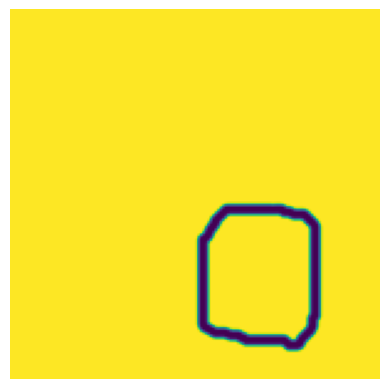

Image 5 (x_77.png):  Incorrect!
True Label: X, Predicted Label: O


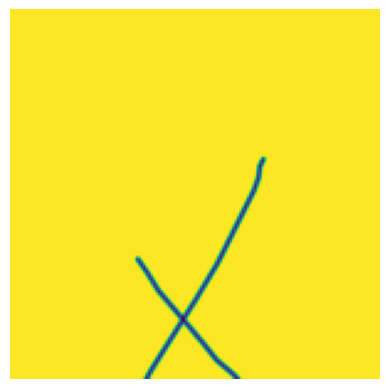

Image 10 (x_16.png):  Incorrect!
True Label: X, Predicted Label: O


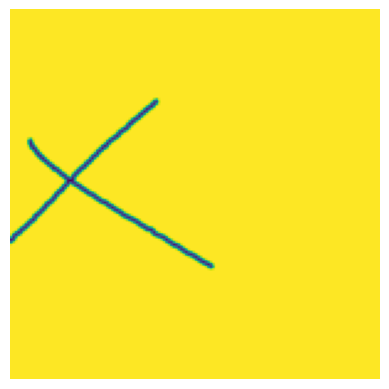

Image 11 (x_127.png):  Incorrect!
True Label: X, Predicted Label: O


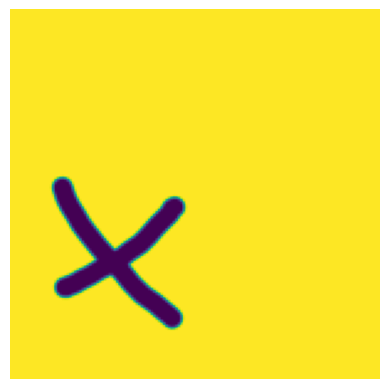

Image 15 (o_47.png):  Incorrect!
True Label: O, Predicted Label: X


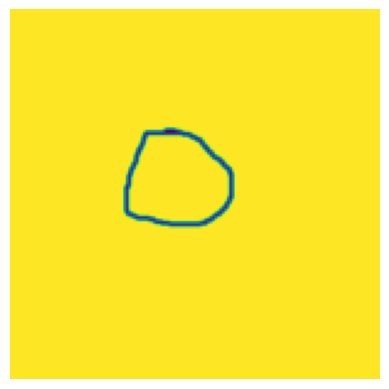

Image 18 (o_136.png):  Incorrect!
True Label: O, Predicted Label: X


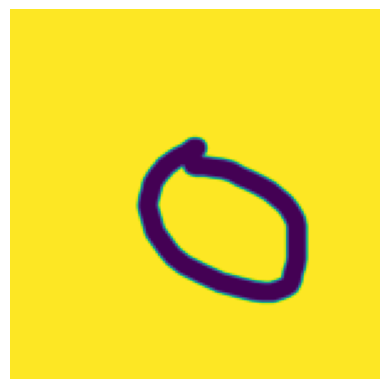

Image 30 (o_14.png):  Incorrect!
True Label: O, Predicted Label: X


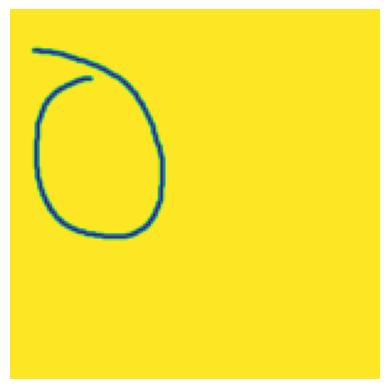

Image 32 (x_78.png):  Incorrect!
True Label: X, Predicted Label: O


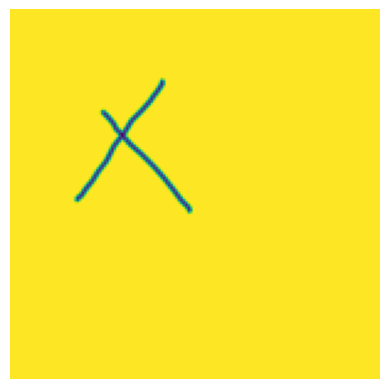

Image 41 (x_68.png):  Incorrect!
True Label: X, Predicted Label: O


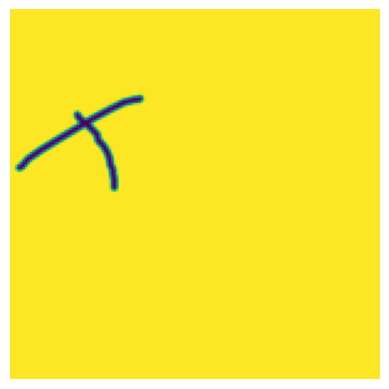

Image 43 (x_67.png):  Incorrect!
True Label: X, Predicted Label: O


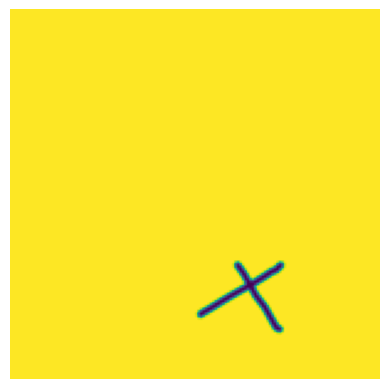

Image 49 (o_127.png):  Incorrect!
True Label: O, Predicted Label: X


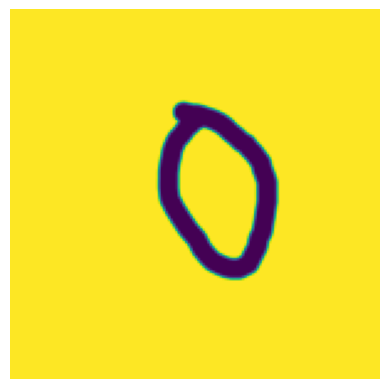

Image 51 (x_43.png):  Incorrect!
True Label: X, Predicted Label: O


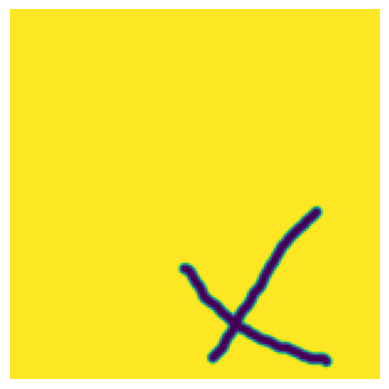

Image 55 (x_39.jpg):  Incorrect!
True Label: X, Predicted Label: O


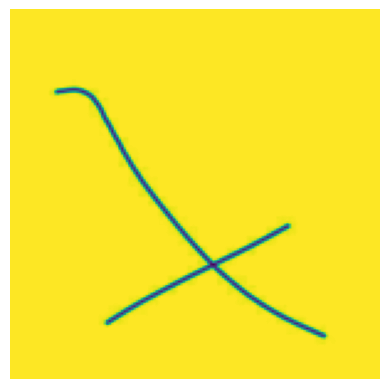

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels, filenames)), [train_size, test_size])

batch_size = 32  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()  # 정답 비교 수정

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 모델 성능 평가 및 이미지 분류 결과 출력
correct = 0
total = 0
classified_results = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 정답 비교 수정

        # 분류 결과 저장
        for i in range(len(inputs)):
            classified_results.append((inputs[i], labels[i].item(), predicted[i].item(), filenames[i]))

print(f'Result: {100 * correct / total}%')

# 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(classified_results):
    image_np = image.numpy().transpose((1, 2, 0))
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
    if true_label == predicted_label:
        #print(f"Image {i + 1}:  Correct!")
        None
    else:
        print(f"Image {i + 1} ({filename}):  Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()
    #print(f"Image {i + 1}: True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
    image_pil.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

batch_size = 32  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# LOOCV 적용
total_correct = 0
total_samples = len(dataset)
val_losses = []
val_accuracies = []

for i in range(total_samples):
    # Leave one out for validation
    val_sample = [dataset[i]]
    val_label = [labels[i]]
    val_filename = [filenames[i]]

    train_samples = dataset[:i] + dataset[i+1:]
    train_labels = torch.cat((labels[:i], labels[i+1:]), dim=0)
    train_filenames = filenames[:i] + filenames[i+1:]

    train_dataset = list(zip(train_samples, train_labels, train_filenames))
    val_dataset = list(zip(val_sample, val_label, val_filename))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = CNN()
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for data in train_loader:
            inputs, labels, _ = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()  # 정답 비교 수정

    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    total_correct += correct_val

    print(f'LOOCV [{i + 1}/{total_samples}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 최종 성능 출력
final_accuracy = 100 * total_correct / total_samples
mean_val_loss = np.mean(val_losses)
mean_val_accuracy = np.mean(val_accuracies)

print(f'Result: {final_accuracy:.2f}%')
print(f'Mean Validation Loss: {mean_val_loss:.4f}')
print(f'Mean Validation Accuracy: {mean_val_accuracy:.2f}%')


LOOCV [1/280], Val Loss: 0.3136, Val Accuracy: 100.00%


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

batch_size = 32  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# LOOCV 적용
total_correct = 0
total_samples = len(dataset)
val_losses = []
val_accuracies = []

for i in range(total_samples):
    # Leave one out for validation
    val_sample = [dataset[i]]
    val_label = [labels[i]]
    val_filename = [filenames[i]]

    train_samples = dataset[:i] + dataset[i+1:]
    train_labels = torch.cat((labels[:i], labels[i+1:]), dim=0)
    train_filenames = filenames[:i] + filenames[i+1:]

    train_dataset = list(zip(train_samples, train_labels, train_filenames))
    val_dataset = list(zip(val_sample, val_label, val_filename))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = CNN()
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for data in train_loader:
            inputs, labels, _ = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()  # 정답 비교 수정

    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    total_correct += correct_val

    print(f'LOOCV [{i + 1}/{total_samples}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 최종 성능 출력
final_accuracy = 100 * total_correct / total_samples
mean_val_loss = np.mean(val_losses)
mean_val_accuracy = np.mean(val_accuracies)
std_val_accuracy = np.std(val_accuracies)

print("\n=== Final LOOCV Results ===")
print(f"Mean Validation Loss: {mean_val_loss:.4f}")
print(f"Mean Validation Accuracy: {mean_val_accuracy:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy:.2f}%")
print(f"Overall Accuracy: {final_accuracy:.2f}%")


LOOCV [1/280], Val Loss: 0.3169, Val Accuracy: 100.00%


IndexError: index 1 is out of bounds for dimension 0 with size 1

Epoch [1/5], Train Loss: 0.5743, Train Accuracy: 73.21%, Val Loss: 0.6964, Val Accuracy: 41.07%
Epoch [2/5], Train Loss: 0.4240, Train Accuracy: 90.18%, Val Loss: 0.6309, Val Accuracy: 71.43%
Epoch [3/5], Train Loss: 0.3871, Train Accuracy: 93.30%, Val Loss: 0.5892, Val Accuracy: 64.29%
Epoch [4/5], Train Loss: 0.3657, Train Accuracy: 95.54%, Val Loss: 0.5668, Val Accuracy: 69.64%
Epoch [5/5], Train Loss: 0.3560, Train Accuracy: 95.98%, Val Loss: 0.5681, Val Accuracy: 69.64%
Result: 69.64285714285714%
Image 4 (o_34.jpg):  Incorrect!
True Label: O, Predicted Label: X


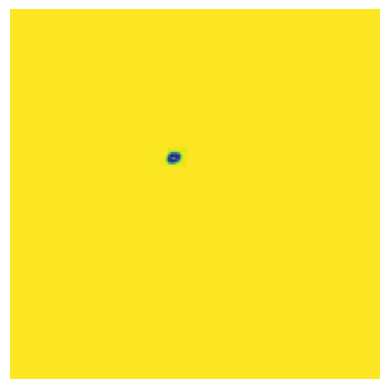

Image 7 (x_133.png):  Incorrect!
True Label: X, Predicted Label: O


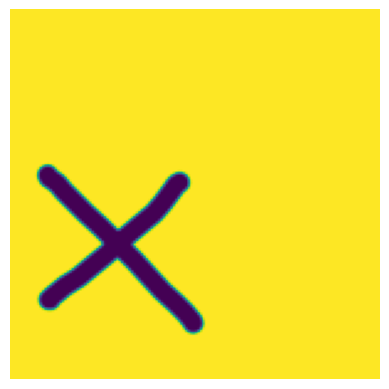

Image 9 (o_136.png):  Incorrect!
True Label: O, Predicted Label: X


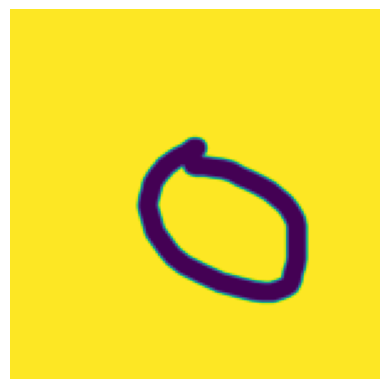

Image 10 (o_47.png):  Incorrect!
True Label: O, Predicted Label: X


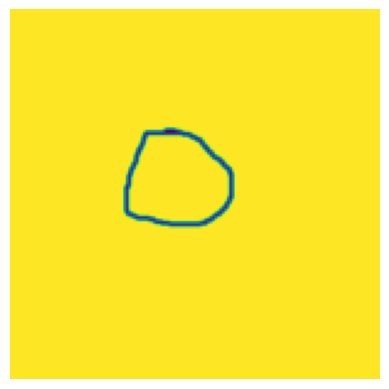

Image 13 (x_127.png):  Incorrect!
True Label: X, Predicted Label: O


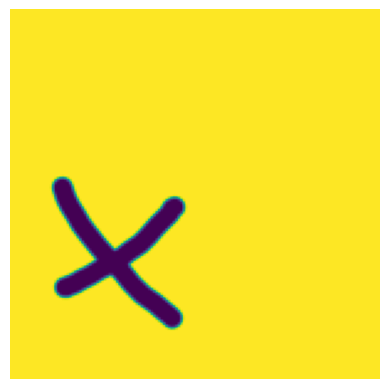

Image 14 (o_36.jpg):  Incorrect!
True Label: O, Predicted Label: X


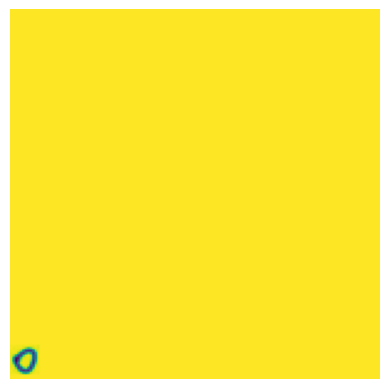

Image 17 (x_103.jpg):  Incorrect!
True Label: X, Predicted Label: O


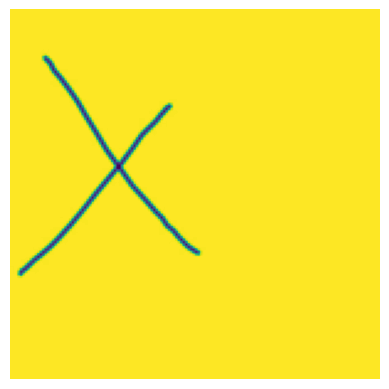

Image 22 (x_92.png):  Incorrect!
True Label: X, Predicted Label: O


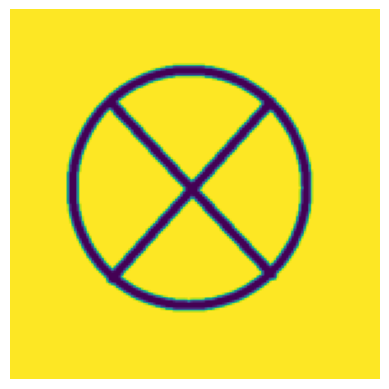

Image 23 (x_118.jpg):  Incorrect!
True Label: X, Predicted Label: O


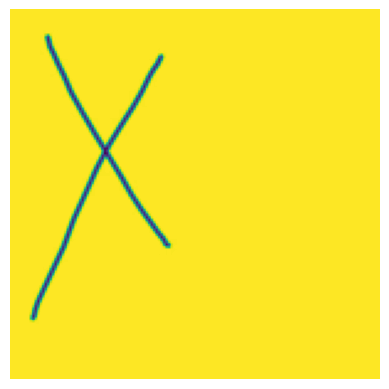

Image 28 (o_24.jpg):  Incorrect!
True Label: O, Predicted Label: X


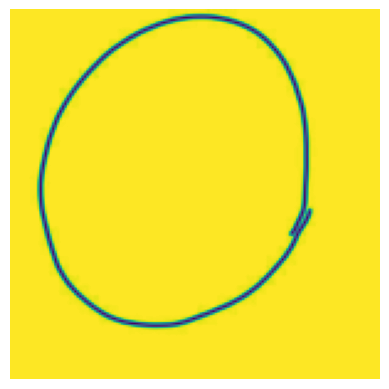

Image 30 (o_4.png):  Incorrect!
True Label: O, Predicted Label: X


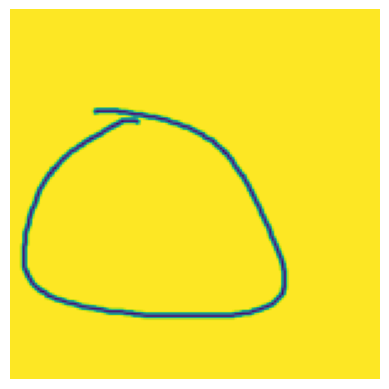

Image 31 (x_135.png):  Incorrect!
True Label: X, Predicted Label: O


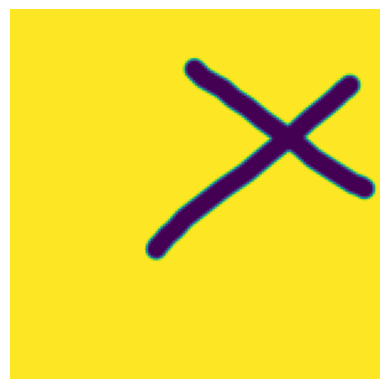

Image 40 (o_59.png):  Incorrect!
True Label: O, Predicted Label: X


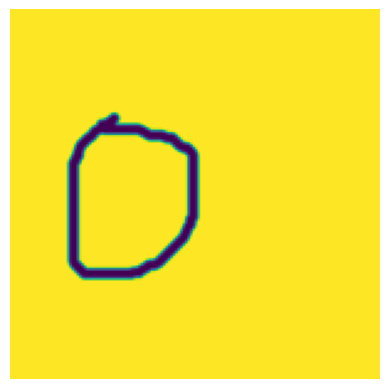

Image 41 (o_117.jpg):  Incorrect!
True Label: O, Predicted Label: X


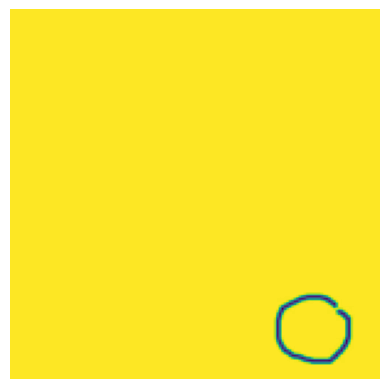

Image 50 (x_16.png):  Incorrect!
True Label: X, Predicted Label: O


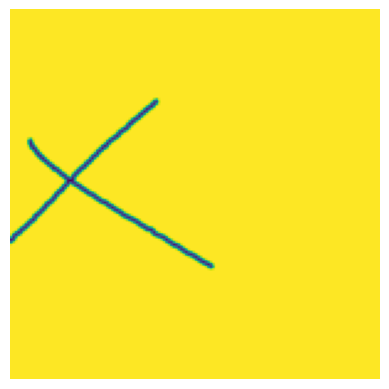

Image 51 (o_54.png):  Incorrect!
True Label: O, Predicted Label: X


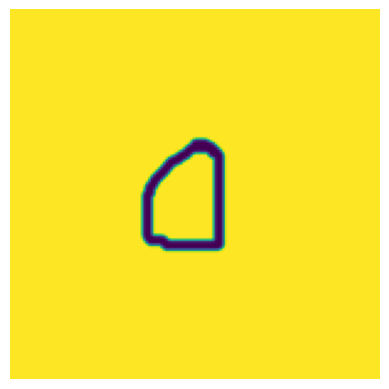

Image 54 (o_127.png):  Incorrect!
True Label: O, Predicted Label: X


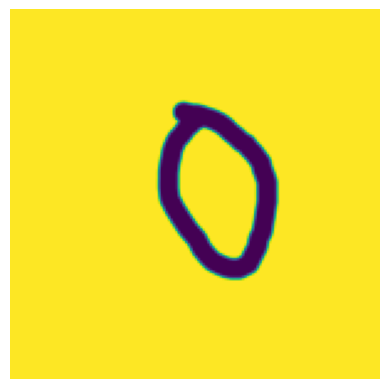

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels, filenames)), [train_size, test_size])

batch_size = 32  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()  # 정답 비교 수정

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 모델 성능 평가 및 이미지 분류 결과 출력
correct = 0
total = 0
classified_results = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 정답 비교 수정

        # 분류 결과 저장
        for i in range(len(inputs)):
            classified_results.append((inputs[i], labels[i].item(), predicted[i].item(), filenames[i]))

print(f'Result: {100 * correct / total}%')

# 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(classified_results):
    image_np = image.numpy().transpose((1, 2, 0))
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
    if true_label == predicted_label:
        #print(f"Image {i + 1}:  Correct!")
        None
    else:
        print(f"Image {i + 1} ({filename}):  Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()
    #print(f"Image {i + 1}: True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
    image_pil.show()


In [ ]:
# 모델 저장 (현재 주석 처리)
# model_save_path = 'model.h'
# torch.save(model.state_dict(), model_save_path)

# 모델 저장 방법
# 위의 주석을 해제하고, 다음 코드를 사용하여 모델을 저장할 수 있습니다:
# model_save_path = 'model.h'  # 저장할 경로 및 파일명
# torch.save(model.state_dict(), model_save_path)  # 모델의 상태를 파일로 저장

# 저장된 모델을 로드하는 방법:
# model = CNN()  # 모델 초기화
# model.load_state_dict(torch.load('model.h'))  # 저장된 모델의 상태를 불러오기
# model.eval()  # 모델을 평가 모드로 설정


Epoch [1/5], Train Loss: 0.6413, Train Accuracy: 62.05%, Val Loss: 0.6814, Val Accuracy: 55.36%
Epoch [2/5], Train Loss: 0.4964, Train Accuracy: 79.46%, Val Loss: 0.6805, Val Accuracy: 46.43%
Epoch [3/5], Train Loss: 0.4250, Train Accuracy: 89.29%, Val Loss: 0.6342, Val Accuracy: 66.07%
Epoch [4/5], Train Loss: 0.4026, Train Accuracy: 91.52%, Val Loss: 0.6159, Val Accuracy: 64.29%
Epoch [5/5], Train Loss: 0.3884, Train Accuracy: 93.75%, Val Loss: 0.5520, Val Accuracy: 82.14%
Overall Accuracy: 82.14%
Image 5 (o_112.jpg): Incorrect!
True Label: O, Predicted Label: X


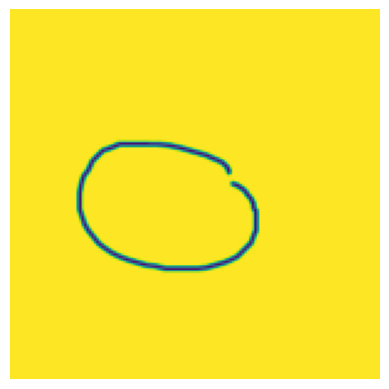

Image 7 (o_136.png): Incorrect!
True Label: O, Predicted Label: X


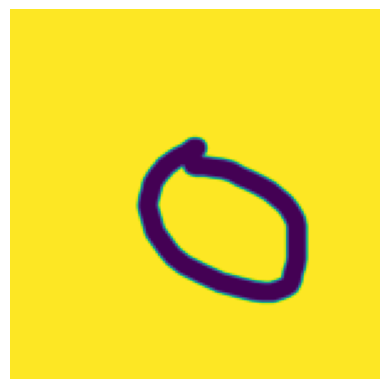

Image 12 (o_94.png): Incorrect!
True Label: O, Predicted Label: X


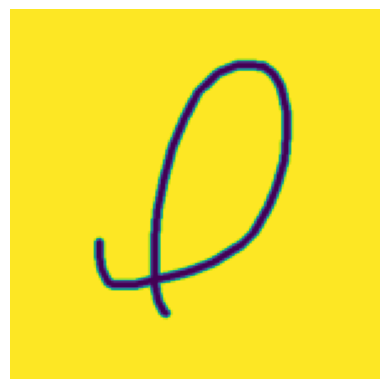

Image 17 (o_111.jpg): Incorrect!
True Label: O, Predicted Label: X


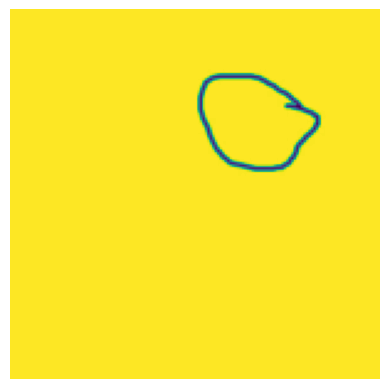

Image 21 (o_76.png): Incorrect!
True Label: O, Predicted Label: X


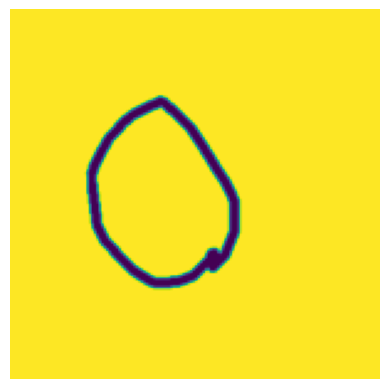

Image 28 (o_51.png): Incorrect!
True Label: O, Predicted Label: X


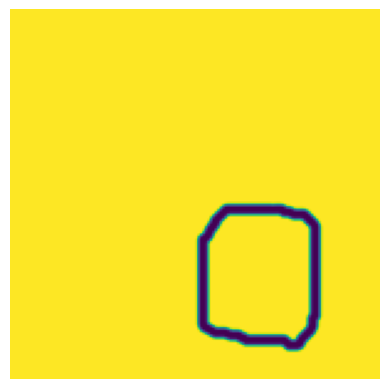

Image 30 (o_27.jpg): Incorrect!
True Label: O, Predicted Label: X


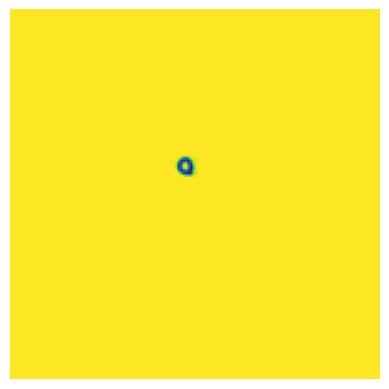

Image 31 (o_74.png): Incorrect!
True Label: O, Predicted Label: X


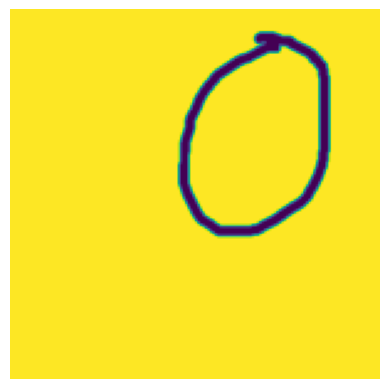

Image 37 (o_90.png): Incorrect!
True Label: O, Predicted Label: X


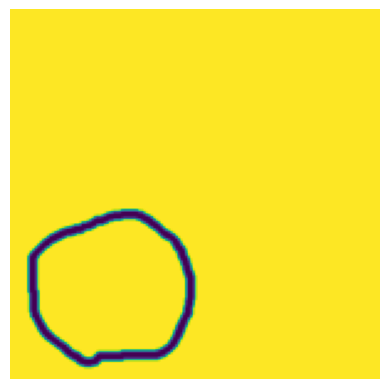

Image 42 (o_36.jpg): Incorrect!
True Label: O, Predicted Label: X


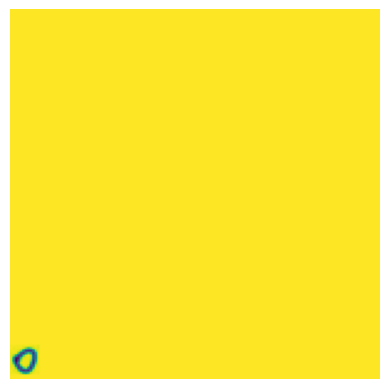

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels, filenames)), [train_size, test_size])

batch_size = 32  # 배치 사이즈
learning_rate = 0.0001  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()  # 정답 비교 수정

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# 모델 성능 평가 및 이미지 분류 결과 출력
correct = 0
total = 0
classified_results = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 정답 비교 수정

        # 분류 결과 저장
        for i in range(len(inputs)):
            classified_results.append((inputs[i], labels[i].item(), predicted[i].item(), filenames[i]))

print(f'Overall Accuracy: {100 * correct / total:.2f}%')

# 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(classified_results):
    if true_label != predicted_label:
        print(f"Image {i + 1} ({filename}): Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_np = image.numpy().transpose((1, 2, 0))
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()

# 모델 저장 (현재 주석 처리)
# model_save_path = 'model.h'
# torch.save(model.state_dict(), model_save_path)

# 모델 저장 방법
# 위의 주석을 해제하고, 다음 코드를 사용하여 모델을 저장할 수 있습니다:
# model_save_path = 'model.h'  # 저장할 경로 및 파일명
# torch.save(model.state_dict(), model_save_path)  # 모델의 상태를 파일로 저장

# 저장된 모델을 로드하는 방법:
# model = CNN()  # 모델 초기화
# model.load_state_dict(torch.load('model.h'))  # 저장된 모델의 상태를 불러오기
# model.eval()  # 모델을 평가 모드로 설정


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

batch_size = 32  # 배치 사이즈 (필요에 따라 수정 가능)
learning_rate = 0.0001  # 러닝 레이트 (필요에 따라 수정 가능)
activation_function = nn.ReLU  # 활성화 함수 (필요에 따라 수정 가능)
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함) (필요에 따라 수정 가능)
padding = 1  # 패딩 (필요에 따라 수정 가능)
stride = 1  # 스트라이드 (필요에 따라 수정 가능)
kernel_size = 3  # 커널 사이즈 (필요에 따라 수정 가능)
optimizer_function = optim.Adam  # 최적화 함수 (필요에 따라 수정 가능)
channels = [1, 4, 36]  # 채널 크기 (필요에 따라 수정 가능)
normalization = nn.BatchNorm2d  # 정규화 (필요에 따라 수정 가능)
num_epochs = 5  # 에포크 수 (필요에 따라 수정 가능)

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

# LOOCV 적용
overall_correct = 0
overall_total = 0
loocv_results = []

for i in range(len(dataset)):
    print(f"Processing LOOCV for sample {i + 1}/{len(dataset)}")
    # LOOCV: 한 개의 샘플을 테스트셋으로 사용하고 나머지를 훈련셋으로 사용
    test_dataset = [(dataset[i], labels[i], filenames[i])]
    train_dataset = [(dataset[j], labels[j], filenames[j]) for j in range(len(dataset)) if j != i]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = CNN()
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels, _ = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

    # 모델 성능 평가
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, filenames = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            overall_total += labels.size(0)
            overall_correct += (predicted == labels).sum().item()  # 정답 비교 수정

            # 분류 결과 저장
            loocv_results.append((inputs[0], labels[0].item(), predicted[0].item(), filenames[0]))

print(f'Overall LOOCV Accuracy: {100 * overall_correct / overall_total:.2f}%')

# 잘못 분류된 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(loocv_results):
    if true_label != predicted_label:
        print(f"Image {i + 1} ({filename}): Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_np = image.numpy().transpose((1, 2, 0))
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()

# 모델 저장 (현재 주석 처리)
# model_save_path = 'model.h'
# torch.save(model.state_dict(), model_save_path)

# 모델 저장 방법
# 위의 주석을 해제하고, 다음 코드를 사용하여 모델을 저장할 수 있습니다:
# model_save_path = 'model.h'  # 저장할 경로 및 파일명
# torch.save(model.state_dict(), model_save_path)  # 모델의 상태를 파일로 저장

# 저장된 모델을 로드하는 방법:
# model = CNN()  # 모델 초기화
# model.load_state_dict(torch.load('model.h'))  # 저장된 모델의 상태를 불러오기
# model.eval()  # 모델을 평가 모드로 설정


Processing LOOCV for sample 1/280
Processing LOOCV for sample 2/280


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

batch_size = 32  # 배치 사이즈 (필요에 따라 수정 가능)
learning_rate = 0.0001  # 러닝 레이트 (필요에 따라 수정 가능)
activation_function = nn.ReLU  # 활성화 함수 (필요에 따라 수정 가능)
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함) (필요에 따라 수정 가능)
padding = 1  # 패딩 (필요에 따라 수정 가능)
stride = 1  # 스트라이드 (필요에 따라 수정 가능)
kernel_size = 3  # 커널 사이즈 (필요에 따라 수정 가능)
optimizer_function = optim.Adam  # 최적화 함수 (필요에 따라 수정 가능)
channels = [1, 4, 36]  # 채널 크기 (필요에 따라 수정 가능)
normalization = nn.BatchNorm2d  # 정규화 (필요에 따라 수정 가능)
num_epochs = 5  # 에포크 수 (필요에 따라 수정 가능)

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

# LOOCV 적용
overall_correct = 0
overall_total = 0
loocv_results = []

for i in range(len(dataset)):
    print(f"Processing LOOCV for sample {i + 1}/{len(dataset)}")
    # LOOCV: 한 개의 샘플을 테스트셋으로 사용하고 나머지를 훈련셋으로 사용
    test_dataset = [(dataset[i], labels[i].item(), filenames[i])]
    train_dataset = [(dataset[j], labels[j].item(), filenames[j]) for j in range(len(dataset)) if j != i]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = CNN()
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for _, data in enumerate(train_loader, 0):
            inputs, labels, _ = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

    # 모델 성능 평가
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, filenames = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            overall_total += labels.size(0)
            overall_correct += (predicted == labels).sum().item()  # 정답 비교 수정

            # 분류 결과 저장
            loocv_results.append((inputs[0], labels[0].item(), predicted[0].item(), filenames[0]))

print(f'Overall LOOCV Accuracy: {100 * overall_correct / overall_total:.2f}%')

# 잘못 분류된 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(loocv_results):
    if true_label != predicted_label:
        print(f"Image {i + 1} ({filename}): Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_np = image.numpy().transpose((1, 2, 0))
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()

# 모델 저장 (현재 주석 처리)
# model_save_path = 'model.h'
# torch.save(model.state_dict(), model_save_path)

# 모델 저장 방법
# 위의 주석을 해제하고, 다음 코드를 사용하여 모델을 저장할 수 있습니다:
# model_save_path = 'model.h'  # 저장할 경로 및 파일명
# torch.save(model.state_dict(), model_save_path)  # 모델의 상태를 파일로 저장

# 저장된 모델을 로드하는 방법:
# model = CNN()  # 모델 초기화
# model.load_state_dict(torch.load('model.h'))  # 저장된 모델의 상태를 불러오기
# model.eval()  # 모델을 평가 모드로 설정


Processing LOOCV for sample 1/280
Processing LOOCV for sample 2/280


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

batch_size = 10  # 배치 사이즈 (필요에 따라 수정 가능)
learning_rate = 0.0001  # 러닝 레이트 (필요에 따라 수정 가능)
activation_function = nn.ReLU  # 활성화 함수 (필요에 따라 수정 가능)
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함) (필요에 따라 수정 가능)
padding = 1  # 패딩 (필요에 따라 수정 가능)
stride = 1  # 스트라이드 (필요에 따라 수정 가능)
kernel_size = 3  # 커널 사이즈 (필요에 따라 수정 가능)
optimizer_function = optim.Adam  # 최적화 함수 (필요에 따라 수정 가능)
channels = [1, 4, 36]  # 채널 크기 (필요에 따라 수정 가능)
normalization = nn.BatchNorm2d  # 정규화 (필요에 따라 수정 가능)
num_epochs = 15  # 에포크 수 (필요에 따라 수정 가능)

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

# 전체 데이터를 학습셋과 테스트셋으로 나누기
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size)]
test_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size, len(dataset))]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for _, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / total_train:.4f}, Accuracy: {100 * correct_train / total_train:.2f}%')

# 모델 성능 평가
model.eval()
overall_correct = 0
overall_total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        overall_total += labels.size(0)
        overall_correct += (predicted == labels).sum().item()  # 정답 비교 수정

print(f'Test Accuracy: {100 * overall_correct / overall_total:.2f}%')

# 잘못 분류된 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(zip(inputs, labels, predicted, filenames)):
    if true_label != predicted_label:
        print(f"Image {i + 1} ({filename}): Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_np = image.numpy().transpose((1, 2, 0))
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()

# 모델 저장 (현재 주석 처리)
# model_save_path = 'model.h'
# torch.save(model.state_dict(), model_save_path)

# 모델 저장 방법
# 위의 주석을 해제하고, 다음 코드를 사용하여 모델을 저장할 수 있습니다:
# model_save_path = 'model.h'  # 저장할 경로 및 파일명
# torch.save(model.state_dict(), model_save_path)  # 모델의 상태를 파일로 저장

# 저장된 모델을 로드하는 방법:
# model = CNN()  # 모델 초기화
# model.load_state_dict(torch.load('model.h'))  # 저장된 모델의 상태를 불러오기
# model.eval()  # 모델을 평가 모드로 설정


Epoch [1/5], Loss: 0.8142, Accuracy: 49.55%
Epoch [2/5], Loss: 0.7618, Accuracy: 54.91%
Epoch [3/5], Loss: 0.6921, Accuracy: 61.61%
Epoch [4/5], Loss: 0.4648, Accuracy: 83.48%
Epoch [5/5], Loss: 0.4654, Accuracy: 84.38%
Test Accuracy: 69.64%


Epoch [1/15], Loss: 0.0201, Accuracy: 61.61%
Model saved with accuracy: 61.61%
Epoch [2/15], Loss: 0.0152, Accuracy: 80.36%
Model saved with accuracy: 80.36%
Epoch [3/15], Loss: 0.0139, Accuracy: 86.61%
Model saved with accuracy: 86.61%
Test Accuracy: 78.57%
Image 1 (o_23.jpg): Incorrect!
True Label: O, Predicted Label: X


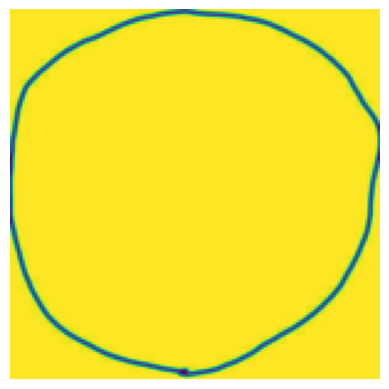

Image 7 (x_118.jpg): Incorrect!
True Label: X, Predicted Label: O


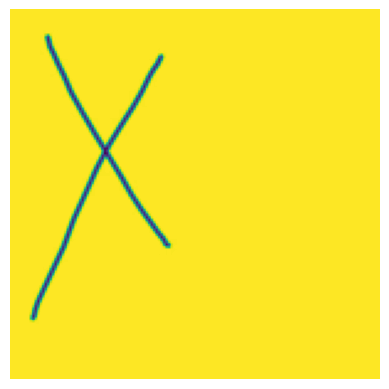

Image 8 (x_103.jpg): Incorrect!
True Label: X, Predicted Label: O


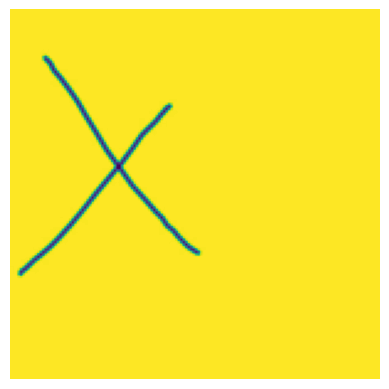

Image 20 (x_26.jpg): Incorrect!
True Label: X, Predicted Label: O


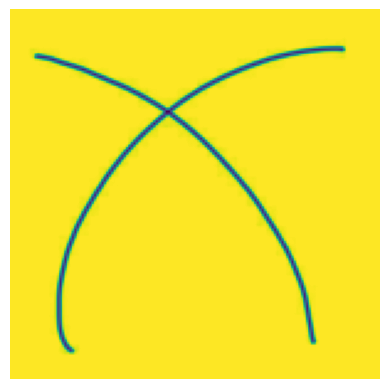

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
model_save_dir = os.path.join(os.path.dirname(path), 'model')  # 모델 저장 디렉토리 경로

# 모델 저장 디렉토리가 없으면 생성
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))  # 파일명 저장

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)  # CrossEntropyLoss와 함께 사용됨

# 원핫인코딩 (참고용 주석)
# one_hot_encoder = OneHotEncoder(sparse=False)
# labels_one_hot = one_hot_encoder.fit_transform(labels.reshape(-1, 1))

batch_size = 32  # 배치 사이즈 (필요에 따라 수정 가능)
learning_rate = 0.0001  # 러닝 레이트 (필요에 따라 수정 가능)
activation_function = nn.ReLU  # 활성화 함수 (필요에 따라 수정 가능)
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함) (필요에 따라 수정 가능)
padding = 1  # 패딩 (필요에 따라 수정 가능)
stride = 1  # 스트라이드 (필요에 따라 수정 가능)
kernel_size = 3  # 커널 사이즈 (필요에 따라 수정 가능)
optimizer_function = optim.Adam  # 최적화 함수 (필요에 따라 수정 가능)
channels = [1, 4, 36]  # 채널 크기 (필요에 따라 수정 가능)
normalization = nn.BatchNorm2d  # 정규화 (필요에 따라 수정 가능)
num_epochs = 15  # 에포크 수 (필요에 따라 수정 가능)

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)  # softmax 적용
        return x

# 전체 데이터를 학습셋과 테스트셋으로 나누기
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size)]
test_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size, len(dataset))]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

# 모델 학습 (정확도가 85% 이상일 때까지 반복)
model_save_path = os.path.join(model_save_dir, 'model.h')
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for _, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # 정답 비교 수정

    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / total_train:.4f}, Accuracy: {train_accuracy:.2f}%')

    if train_accuracy > best_accuracy:
        best_accuracy = train_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

    if best_accuracy >= 85.0:
        break

# 모델 성능 평가
model.eval()
overall_correct = 0
overall_total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        overall_total += labels.size(0)
        overall_correct += (predicted == labels).sum().item()  # 정답 비교 수정

print(f'Test Accuracy: {100 * overall_correct / overall_total:.2f}%')

# 잘못 분류된 이미지와 분류 결과 출력
for i, (image, true_label, predicted_label, filename) in enumerate(zip(inputs, labels, predicted, filenames)):
    if true_label != predicted_label:
        print(f"Image {i + 1} ({filename}): Incorrect!")
        print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
        image_np = image.numpy().transpose((1, 2, 0))
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
        image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
        plt.imshow(image_numpy)
        plt.axis('off')  # 축 제거
        plt.show()



In [19]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
model_save_dir = os.path.join(os.path.dirname(path), 'model')  # 모델 저장 디렉토리 경로

if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

#원핫 인코딩 -> 안해도 댐
one_hot_encoder = OneHotEncoder(sparse=False)
labels_one_hot = one_hot_encoder.fit_transform(labels.reshape(-1, 1))

batch_size = 20  # 배치 사이즈
learning_rate = 0.0005  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5  # 에포크 수
def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# 데이터 나누기(학습,테스트)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size)]
test_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size, len(dataset))]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

#반복학습
model_save_path = os.path.join(model_save_dir, 'model.h')
best_accuracy = 0.0

while best_accuracy < 85.0:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for _, data in enumerate(train_loader, 0):
            inputs, labels, _ = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / total_train:.4f}, Accuracy: {train_accuracy:.2f}%')

    # 모델 성능 평가
    model.eval()
    overall_correct = 0
    overall_total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, filenames = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            overall_total += labels.size(0)
            overall_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * overall_correct / overall_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

    if best_accuracy >= 85.0:
        break

# 잘못 분류된 이미지와 분류 결과 출력
model.load_state_dict(torch.load(model_save_path))
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for i, (image, true_label, predicted_label, filename) in enumerate(zip(inputs, labels, predicted, filenames)):
            if true_label != predicted_label:
                print(f"Image {i + 1} ({filename}): Incorrect!")
                print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
                image_np = image.numpy().transpose((1, 2, 0))
                image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
                image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
                plt.imshow(image_numpy)
                plt.axis('off')  # 축 제거
                plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch [1/5], Loss: 0.0334, Accuracy: 63.84%
Epoch [2/5], Loss: 0.0296, Accuracy: 77.23%
Epoch [3/5], Loss: 0.0261, Accuracy: 82.14%
Epoch [4/5], Loss: 0.0246, Accuracy: 85.71%
Epoch [5/5], Loss: 0.0225, Accuracy: 87.95%
Test Accuracy: 78.57%
Model saved with accuracy: 78.57%
Epoch [1/5], Loss: 0.0227, Accuracy: 89.73%
Epoch [2/5], Loss: 0.0218, Accuracy: 90.18%
Epoch [3/5], Loss: 0.0224, Accuracy: 90.62%
Epoch [4/5], Loss: 0.0213, Accuracy: 91.07%
Epoch [5/5], Loss: 0.0212, Accuracy: 91.07%
Test Accuracy: 76.79%
Epoch [1/5], Loss: 0.0211, Accuracy: 91.52%
Epoch [2/5], Loss: 0.0210, Accuracy: 91.52%
Epoch [3/5], Loss: 0.0210, Accuracy: 91.52%
Epoch [4/5], Loss: 0.0210, Accuracy: 91.52%
Epoch [5/5], Loss: 0.0210, Accuracy: 91.52%
Test Accuracy: 78.57%
Epoch [1/5], Loss: 0.0210, Accuracy: 91.52%
Epoch [2/5], Loss: 0.0206, Accuracy: 92.41%
Epoch [3/5], Loss: 0.0206, Accuracy: 92.41%
Epoch [4/5], Loss: 0.0213, Accuracy: 92.86%
Epoch [5/5], Loss: 0.0204, Accuracy: 92.86%
Test Accuracy: 80.36

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch [1/5], Loss: 0.0299, Accuracy: 75.45%
Test Accuracy: 53.57%
Model saved with accuracy: 53.57%
Epoch [2/5], Loss: 0.0251, Accuracy: 82.59%
Test Accuracy: 60.71%
Model saved with accuracy: 60.71%
Epoch [3/5], Loss: 0.0257, Accuracy: 83.48%
Test Accuracy: 67.86%
Model saved with accuracy: 67.86%
Epoch [4/5], Loss: 0.0231, Accuracy: 88.84%
Test Accuracy: 85.71%
Model saved with accuracy: 85.71%
Epoch [5/5], Loss: 0.0203, Accuracy: 92.86%
Test Accuracy: 83.93%
Image 11 (x_22.jpg): Incorrect!
True Label: X, Predicted Label: O


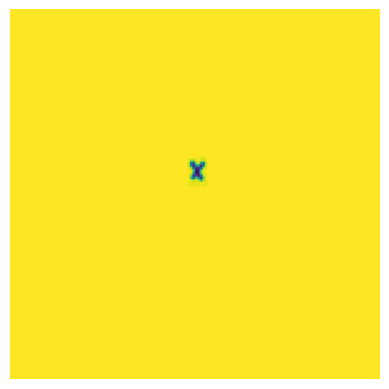

Image 17 (o_35.jpg): Incorrect!
True Label: O, Predicted Label: X


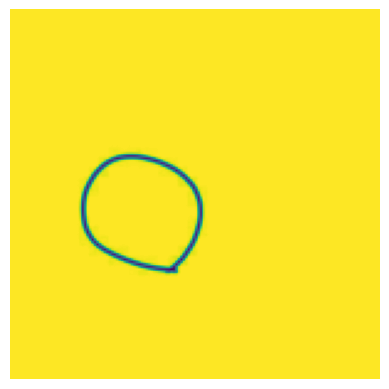

Image 8 (o_39.jpg): Incorrect!
True Label: O, Predicted Label: X


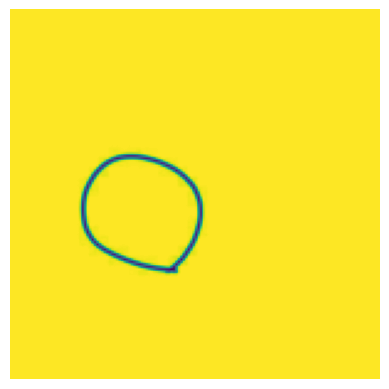

Image 13 (o_23.jpg): Incorrect!
True Label: O, Predicted Label: X


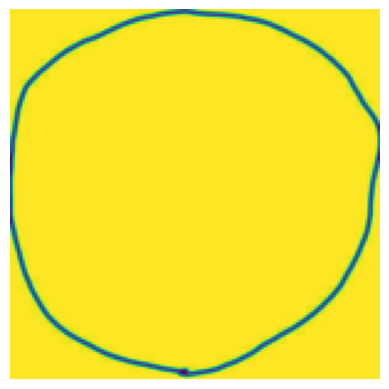

Image 19 (x_118.jpg): Incorrect!
True Label: X, Predicted Label: O


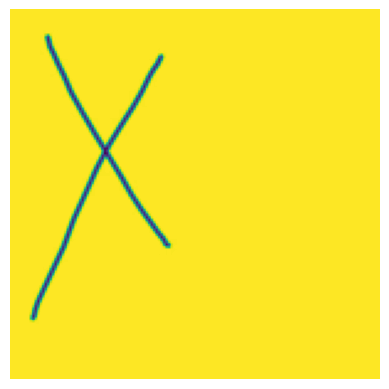

Image 20 (x_103.jpg): Incorrect!
True Label: X, Predicted Label: O


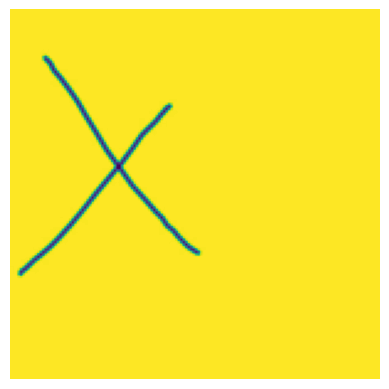

Image 12 (x_26.jpg): Incorrect!
True Label: X, Predicted Label: O


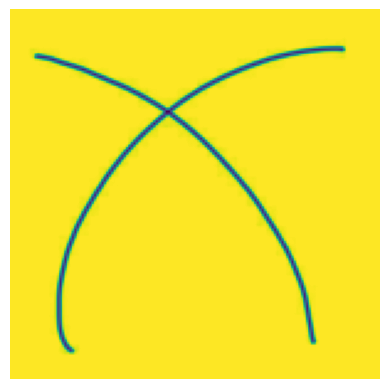

Image 14 (x_115.jpg): Incorrect!
True Label: X, Predicted Label: O


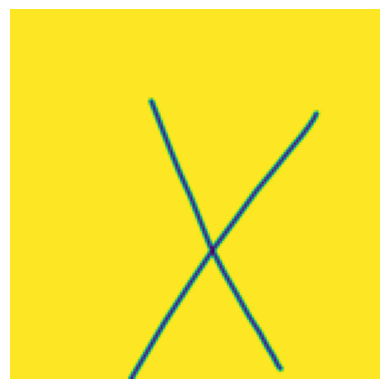

In [20]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

# 랜덤 시드 설정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 사용 여부 설정
use_seed = False  # True로 설정하면 랜덤 시드를 고정, False로 설정하면 랜덤 시드 사용 안함
seed = 42

if use_seed:
    set_seed(seed)

path = r"/content/sample_data/image"  # 이미지 디렉토리 경로 고정
model_save_dir = os.path.join(os.path.dirname(path), 'model')  # 모델 저장 디렉토리 경로

if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = []
labels = []
filenames = []

# 이미지 전처리
for idx in image_list:
    image = Image.open(idx).convert('RGB')
    image = transform(image)
    dataset.append(image)
    filenames.append(os.path.basename(idx))

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# 원핫 인코딩
one_hot_encoder = OneHotEncoder(sparse=False)
labels_one_hot = torch.tensor(one_hot_encoder.fit_transform(labels.reshape(-1, 1)), dtype=torch.float32)

batch_size = 20  # 배치 사이즈
learning_rate = 0.0005  # 러닝 레이트
activation_function = nn.ReLU  # 활성화 함수
num_hidden_layers = 5  # 히든레이어 계층수 (출력층 포함)
padding = 1  # 패딩
stride = 1  # 스트라이드
kernel_size = 3  # 커널 사이즈
optimizer_function = optim.Adam  # 최적화 함수
channels = [1, 4, 36]  # 채널 크기
normalization = nn.BatchNorm2d  # 정규화
num_epochs = 5  # 에포크 수

def collate_fn(batch):
    images, labels, filenames = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels), filenames

# CNN 모델 수정
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[1]),
            activation_function(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel_size, stride=stride, padding=padding),
            normalization(channels[2]),
            activation_function(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(channels[2] * 37 * 37, 2)
        self.softmax = nn.Softmax(dim=1)  # softmax 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# 데이터 나누기(학습,테스트)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size)]
test_dataset = [(dataset[i], labels[i].item(), filenames[i]) for i in range(train_size, len(dataset))]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = CNN()
optimizer = optimizer_function(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용

# 학습 루프
model_save_path = os.path.join(model_save_dir, 'model.h')
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for _, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / total_train:.4f}, Accuracy: {train_accuracy:.2f}%')

    # 모델 성능 평가
    model.eval()
    overall_correct = 0
    overall_total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, filenames = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            overall_total += labels.size(0)
            overall_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * overall_correct / overall_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

# 잘못 분류된 이미지와 분류 결과 출력
model.load_state_dict(torch.load(model_save_path))
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels, filenames = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for i, (image, true_label, predicted_label, filename) in enumerate(zip(inputs, labels, predicted, filenames)):
            if true_label != predicted_label:
                print(f"Image {i + 1} ({filename}): Incorrect!")
                print(f"True Label: {'O' if true_label == 0 else 'X'}, Predicted Label: {'O' if predicted_label == 0 else 'X'}")
                image_np = image.numpy().transpose((1, 2, 0))
                image_pil = Image.fromarray((image_np * 255).astype(np.uint8).squeeze())
                image_numpy = image.permute(1, 2, 0).numpy()  # (높이, 너비, 채널) 순서로 변경
                plt.imshow(image_numpy)
                plt.axis('off')  # 축 제거
                plt.show()
